In [253]:
import numpy as np
import pandas as pd
import scipy.stats as stats

# N=3 case

In [41]:
N = 3 
T = 3 
steps = 300 
dt = T / steps 
N_total = N + 1
rf_rate = 0.03 



## default intensity X(t) and default events

<span style="color: red"> can change: Initial intensities, w, mean reversion (can change to number), volatility (can change to number), conterparty intensity

In [322]:
def mu(X):
    return -0.1 * X  # Mean-reverting drift (example)

def sigma(X):
    return 0.05 * np.sqrt(X) 

In [294]:
# Custom initial default intensities (X) including the counterparty (N+1th entity)
X = np.array([0.2, 0.3, 0.4, 0.0])  # Initial intensities for 3 entities + counterparty
# Note: X[N] (the counterparty) starts at 0 since it depends on the first N entities.


w = np.array([
    [0.0, 0.1, 0.2, 0.0],  # Impact of entities 2, 3, and counterparty on entity 1
    [0.1, 0.0, 0.1, 0.0],  # Impact of entities 1, 3, and counterparty on entity 2
    [0.2, 0.1, 0.0, 0.0],  # Impact of entities 1, 2, and counterparty on entity 3
    [0.0, 0.0, 0.0, 0.0]   # Counterparty's intensity depends on N's default
])

# Simulation placeholders
times = np.linspace(0, T, steps)
X_trajectory = np.zeros((N_total, steps))  # Store trajectories of all entities
default_times = [None] * N_total  # Track default times for all entities
is_defaulted = np.zeros(N_total, dtype=bool)  # Track default status for all entities

# Initialize intensities
X_trajectory[:, 0] = X  # Store initial intensities

# Simulate defaults
for t in range(1, steps):  # Start from the second time step
    current_time = t * dt

    # Copy previous intensities as the baseline for this step
    X_t = X_trajectory[:, t - 1]

    # Update default intensities for first N entities using SDE
    dW = np.random.normal(0, np.sqrt(dt), size=N_total)  # Brownian increments
    dJ = w @ is_defaulted  # Contagion jump adjustments
    X_t[:N] += mu(X_t[:N]) * dt + sigma(X_t[:N]) * dW[:N] + dJ[:N]  # Euler-Maruyama for first N entities
    X_t[:N] = np.maximum(X_t[:N], 0)  # Ensure non-negative intensities

    # Activate counterparty (N+1th) intensity if one or more defaults occurred in the first N
    if any(is_defaulted[:N]):
        X_t[N] = 0.1 + 0.1 * np.sum(is_defaulted[:N])  # Counterparty intensity depends on N defaults
        X_t[N] += mu(X_t[N]) * dt + sigma(X_t[N]) * dW[N]  # SDE update
        X_t[N] = max(X_t[N], 0)  # Ensure non-negative intensity

    # Store updated intensities in the trajectory
    X_trajectory[:, t] = X_t

    # Check for defaults
    for i in range(N_total):
        if not is_defaulted[i]:
            default_prob = 1 - np.exp(-X_t[i] * dt)  # Poisson process default
            if np.random.uniform() < default_prob:
                is_defaulted[i] = True
                default_times[i] = current_time
                print(f"Entity {i+1} defaulted at time {current_time:.2f}")

    # Stop if all entities have defaulted
    if all(is_defaulted):
        X_trajectory[:, t:] = X_trajectory[:, t][:, None]  # Copy final intensities forward
        break

# Print results
print("\nDefault times:")
for i, t in enumerate(default_times):
    print(f"Entity {i+1}: {t if t is not None else 'Survived'}")


Entity 2 defaulted at time 0.17
Entity 3 defaulted at time 0.22
Entity 1 defaulted at time 0.28
Entity 4 defaulted at time 1.94

Default times:
Entity 1: 0.28
Entity 2: 0.17
Entity 3: 0.22
Entity 4: 1.94


In [323]:
X_trajectory 

array([[ 4.22877639,  4.2258374 ,  4.218078  , ..., 19.38569885,
        19.38569885, 19.38569885],
       [11.25922233, 11.25523181, 11.22760126, ..., 40.83928398,
        40.83928398, 40.83928398],
       [20.91736408, 20.89258322, 20.83682908, ..., 80.54275185,
        80.54275185, 80.54275185],
       [ 0.39970707,  0.39970707,  0.39970707, ...,  0.39522505,
         0.39522505,  0.39522505]])

In [325]:
is_defaulted

array([ True,  True,  True,  True])

<span style="color: purple"> default intensities for 1 to N are updating from params for default intensities , i.e. mu, sigma, init intensity and w. default intensities for N+1 default intensity depend on how many of entity 1 to N default. 

<span style="color: purple"> default events notes: once default, then default boolean for that entity remains True for the rest of the times

## calculate cash flow

<span style="color: red"> can change: rf (can change to function), LGD, spread

In [299]:
# Parameters for CDS cash flow calculations
recovery_rate = 0.4
lgd = 1 - recovery_rate  # Loss Given Default
maturity = T  # CDS maturity equals simulation time horizon
spreads = np.array([0.2, 0.15, 0.2, 0.3])  # Annualized spreads for entities 1, 2, 3, and counterparty
payment_frequency = 0.25  # Quarterly payments


# Initialize discounted cash flow trackers
discounted_premium_leg = np.zeros(N + 1)
discounted_protection_leg = np.zeros(N + 1)

# Calculate discounted cash flows for each entity
for i in range(N + 1):
    # Determine the default time for the entity
    default_time = default_times[i]
    if default_time is None:
        # No default, entity survives to maturity
        default_time = maturity

    # Discounted Premium Leg: Sum of discounted periodic payments
    num_premium_payments = int(min(default_time, maturity) / payment_frequency)
    payment_times = np.arange(1, num_premium_payments + 1) * payment_frequency  # Times of payments
    discount_factors = np.exp(-rf_rate * payment_times)  # Discount factor for each payment
    discounted_premium_leg[i] = np.sum(discount_factors * payment_frequency * spreads[i])

    # Discounted Protection Leg: Discounted LGD payment upon default
    if default_times[i] is not None:  # Default occurred
        discounted_protection_leg[i] = lgd * np.exp(-rf_rate * default_times[i])

# Output results
print("\nDiscounted Cash Flows:")
for i in range(N + 1):
    entity = f"Entity {i+1}" if i < N else "Counterparty"
    print(f"{entity}:")
    print(f"  Discounted Premium Leg: {discounted_premium_leg[i]:.4f}")
    print(f"  Discounted Protection Leg: {discounted_protection_leg[i]:.4f}")



Discounted Cash Flows:
Entity 1:
  Discounted Premium Leg: 0.0496
  Discounted Protection Leg: 0.5950
Entity 2:
  Discounted Premium Leg: 0.0000
  Discounted Protection Leg: 0.5969
Entity 3:
  Discounted Premium Leg: 0.0000
  Discounted Protection Leg: 0.5961
Counterparty:
  Discounted Premium Leg: 0.5095
  Discounted Protection Leg: 0.5661


## compute F and g

<span style="color: purple">  F: Represents the expected value of the default leg (protection payment), accounting for the discounted cash flows and the likelihood of default. F = E[LGD*exp(-rf*tau)], where tau is the default time
    
<span style="color: purple">  g: Represents the expected value of the premium leg, i.e., the total premium payments made up to the time of default (or maturity). It includes discounting and the survival probability. 
    g = E[integral<0, min(tau, T)>(spread*exp(-rf*t))dt]

In [303]:
# Function to calculate survival probabilities
def survival_probability(X, dt):
    """
    Approximates the survival probability S(t) = P(tau > t).
    """
    cumulative_hazard = np.cumsum(X * dt)  # Integral of intensity
    return np.exp(-cumulative_hazard)

# Time step
dt = T / steps
time_grid = np.linspace(0, T, steps)

# Initialize F(t) and g(t) for each entity
F_t = np.zeros((N + 1, steps))
g_t = np.zeros((N + 1, steps))

for i in range(N + 1):
    # Intensity path for the entity
    intensity_path = X_trajectory[i, :]  # Intensity path for entity i over all time steps

    # Calculate survival probabilities
    S = survival_probability(intensity_path, dt)

    # Loop over time steps to compute time-dependent F(t) and g(t)
    for t_idx in range(steps):
        # Time grid for integration
        future_time = time_grid[t_idx:]
        future_intensity = intensity_path[t_idx:]
        future_S = S[t_idx:]

        # Discount factors
        future_discount = np.exp(-rf_rate * (future_time - time_grid[t_idx]))

        # F(t): Default leg
        default_density = future_intensity * future_S  # Default probability density
        F_t[i, t_idx] = np.sum(default_density * lgd * future_discount * dt)

        # g(t): Premium leg
        g_t[i, t_idx] = np.sum(future_S * spreads[i] * future_discount * dt)


In [311]:
(F_t[:, 1]-g_t[:, 1]).sum()

1.3301764955357624

In [312]:
F_t[:, 1]

array([0.55750237, 0.50508944, 0.43733485, 0.3972054 ])

## compute theta

In [305]:
# Compute theta_GKW using time-dependent F(t) and g(t)
theta_GKW = np.zeros(steps)
for t_idx in range(steps):
    # Numerator: U^CDS = F(t) - g(t) (time-dependent)
    U_cds_t = np.sum(F_t[:, t_idx] - g_t[:, t_idx])  # Aggregate U^CDS across entities

    # Denominator: Phi (sum of default intensities at time t)
    Phi_t = np.sum(X_trajectory[:, t_idx]) + 1e-6  # Avoid division by zero

    # Calculate theta_GKW for this time step
    theta_GKW[t_idx] = U_cds_t / Phi_t

# Output final theta_GKW
print("\nTheta_GKW at final time step:")
print(f"  {theta_GKW[-1]:.4f}")



Theta_GKW at final time step:
  -0.0000


In [319]:
F_t[:, 0] - g_t[:,0]

array([ 0.54068271,  0.55277964,  0.53038596, -0.11305187])

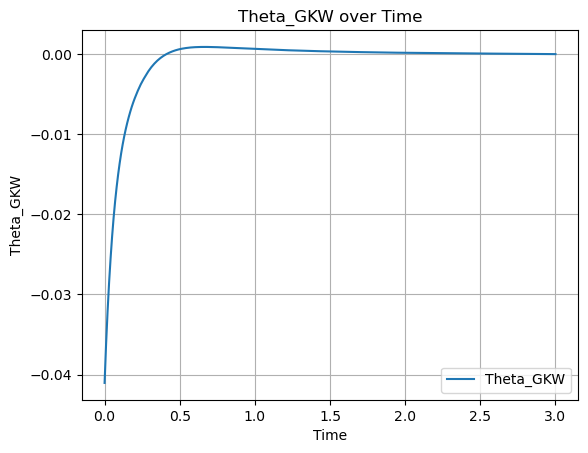

In [320]:
plt.plot(time_grid, -theta_GKW, label="Theta_GKW")
plt.xlabel("Time")
plt.ylabel("Theta_GKW")
plt.title("Theta_GKW over Time")
plt.legend()
plt.grid(True)
plt.show()



<span style="color: purple"> phi reflects the level of systemic risk in the CDS portfolio, A higher phi implies a higher likelihood of defaults across the system, requiring the net value F(t)−g(t) to be scaled appropriately. it captures the current state of risk in the system at t.